In [1]:
from models import *
import time
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from collections import namedtuple
from utils.spectral import spectrum
from pydub import AudioSegment
import matplotlib.pyplot as plt
import re

class SpectrumCNN(nn.Module):
    def __init__(self):
        super(SpectrumCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.Conv2d(8, 8, 3, 1, 1),
            # nn.Conv2d(8, 8, 3, 1, 1),
            # nn.Conv2d(8, 8, 3, 1, 1),
            nn.Conv2d(8, 2, 3, 1, 1),
        ])
        self.pools = nn.ModuleList([
            nn.MaxPool2d(3, 2, 1),
            nn.MaxPool2d(3, 2, 1),
        ])
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.1),
            nn.Dropout(0.1),
            nn.Dropout(0.1),
        ])
        self.layernorms = nn.ModuleList([
            #nn.LayerNorm([352, 161]),
            #nn.LayerNorm([176, 81]),
            #nn.LayerNorm([88, 41])
            
            #nn.LayerNorm([161, 352]),
            #nn.LayerNorm([81, 176]),
            #nn.LayerNorm([41, 88])
            nn.LayerNorm(352),
            nn.LayerNorm(176),
            nn.LayerNorm(88)
        ])

    def forward(self, x):
        c = self.convs
        p = self.pools
        d = self.dropouts
        n = self.layernorms
        relu = nn.functional.relu
        #print(x.shape)
        
        x = relu(c[0](x)) + x
        x = relu(c[1](x)) + x
        x = n[0](d[0](x))
        
        x = p[0](x)
        
        x = relu(c[2](x)) + x
        x = relu(c[3](x)) + x
        x = n[1](d[1](x))
        
        x = p[1](x)
        #print(x.shape)
        
        
        x = relu(c[4](x)) + x
        x = c[5](x)
        return torch.sigmoid(x)

net = SpectrumCNN()
net.load_state_dict(torch.load('outputs/checkpoint'))
net.cuda()


SpectrumCNN(
  (convs): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(8, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pools): ModuleList(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.1, inplace=False)
  )
  (layernorms): ModuleList(
    (0): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((176,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((88,), 

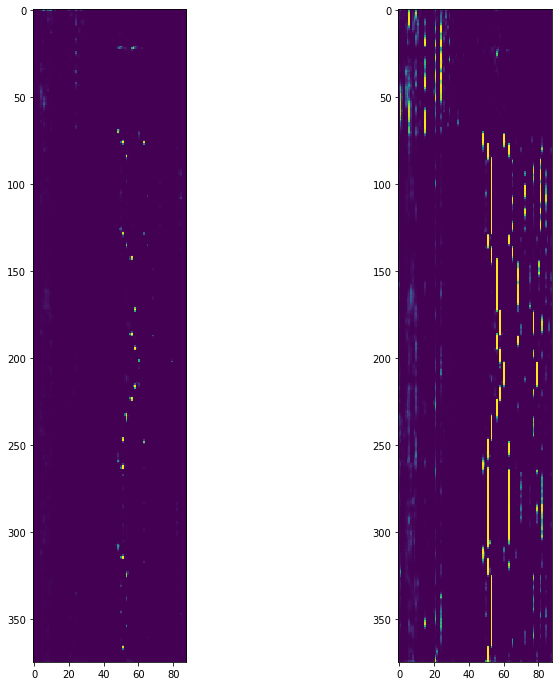

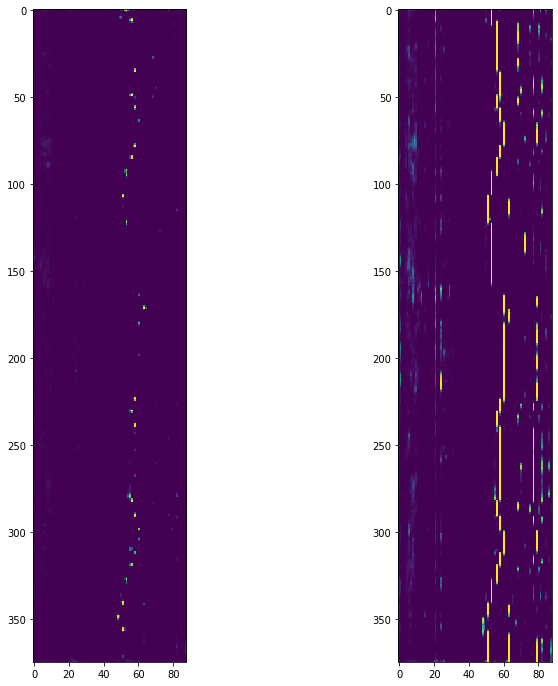

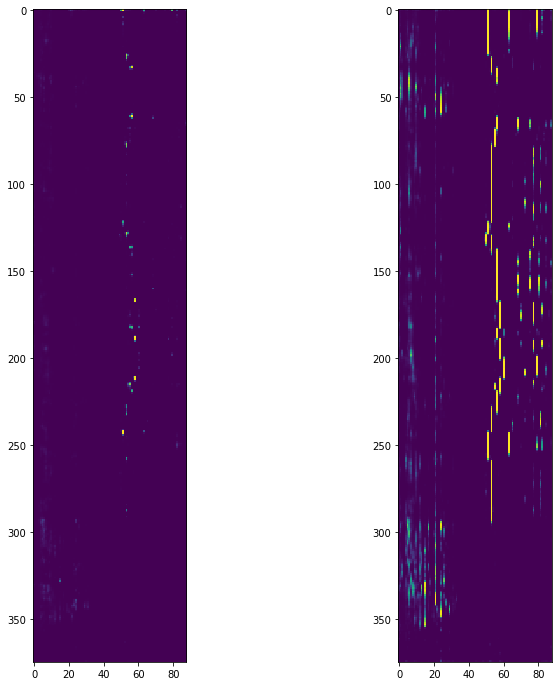

NameError: name 'math' is not defined

In [11]:
from preprocess import clip_and_spectrum, convert_midi_to_mp3, convert_midi_to_label, label_clip_to_onehot

mp3 = np.array(AudioSegment.from_mp3('harm.mp3').get_array_of_samples()) / 32768
for x in clip_and_spectrum(mp3):
    x = x.cuda()[:1500]
    x.unsqueeze_(0)
    x.unsqueeze_(0)
    ypred = net(x).cpu().data[0]
    plt.figure(figsize=(12,12))
    plt.subplot(121); plt.imshow(ypred[0])
    plt.subplot(122); plt.imshow(ypred[1])
    plt.show()


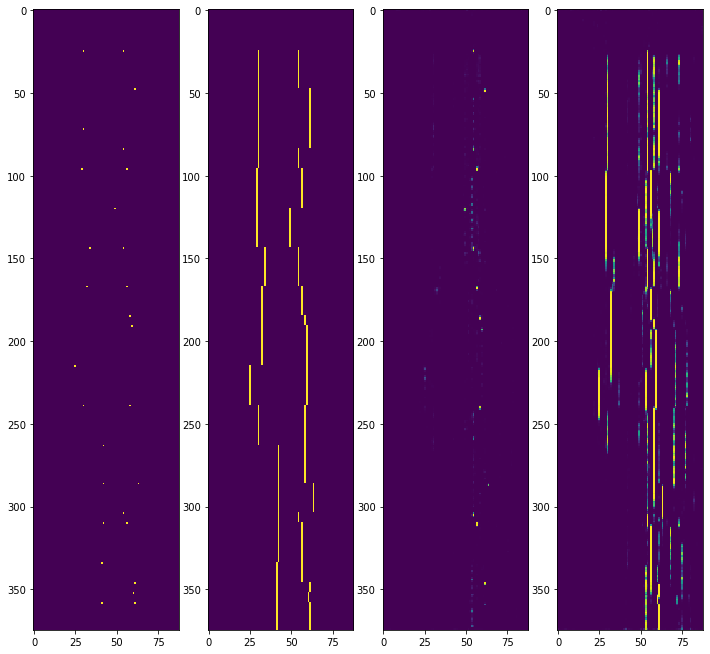

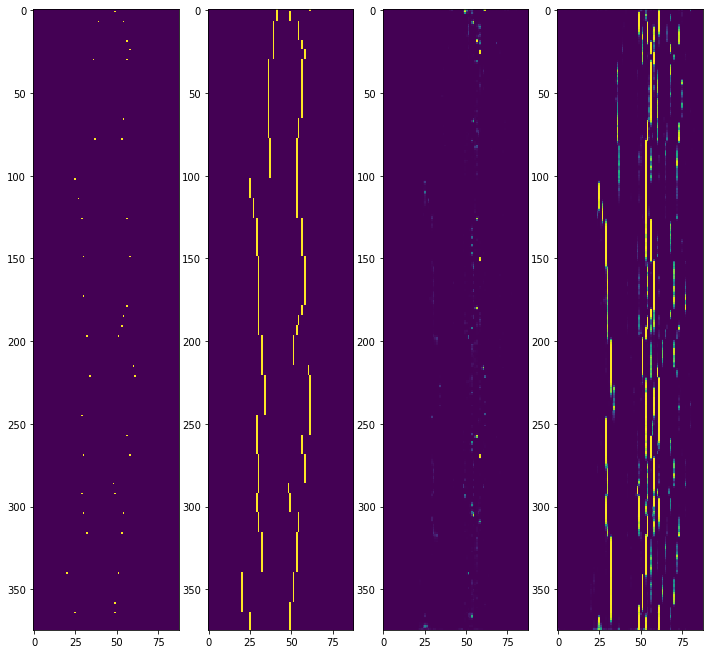

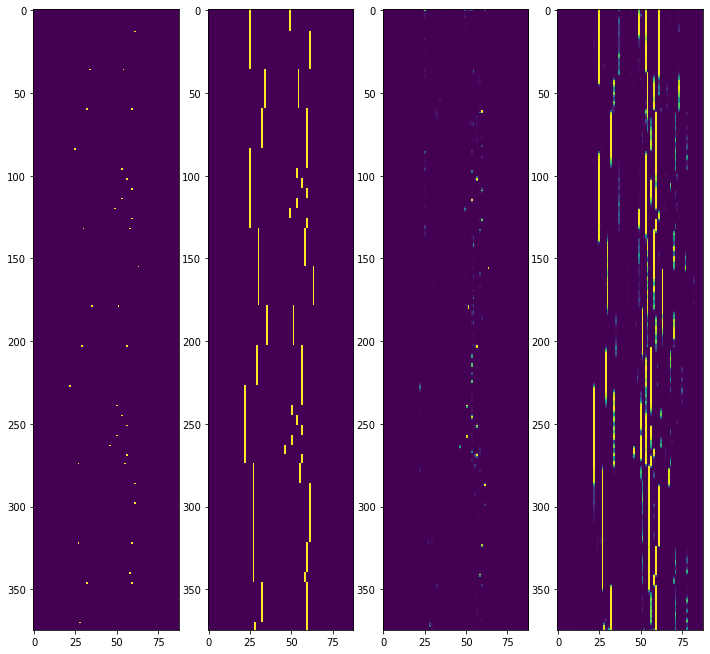

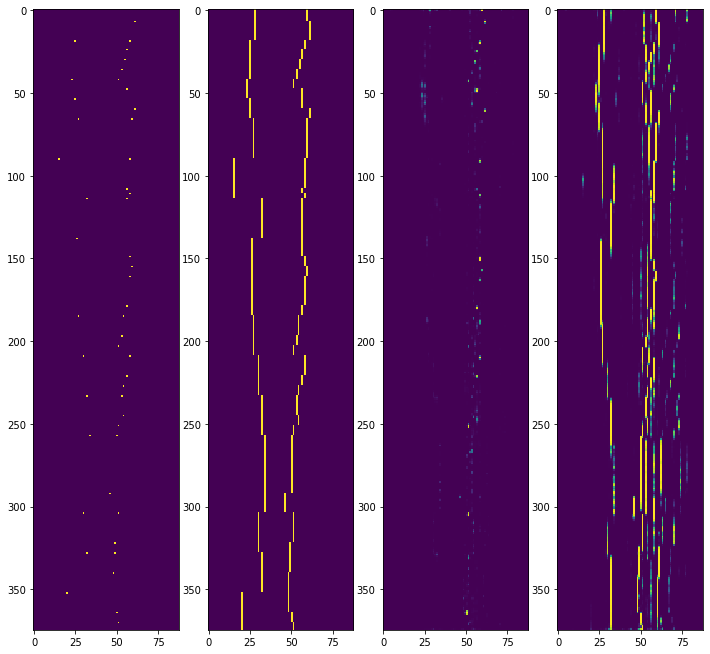

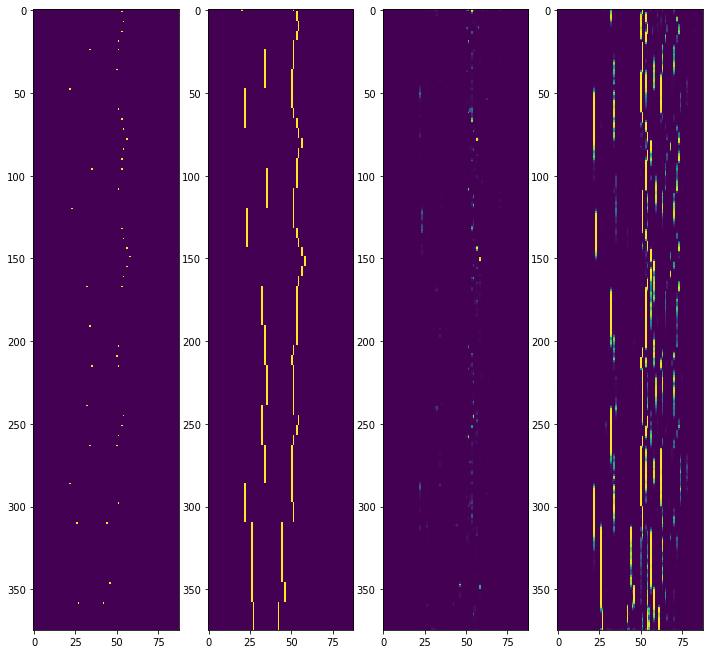

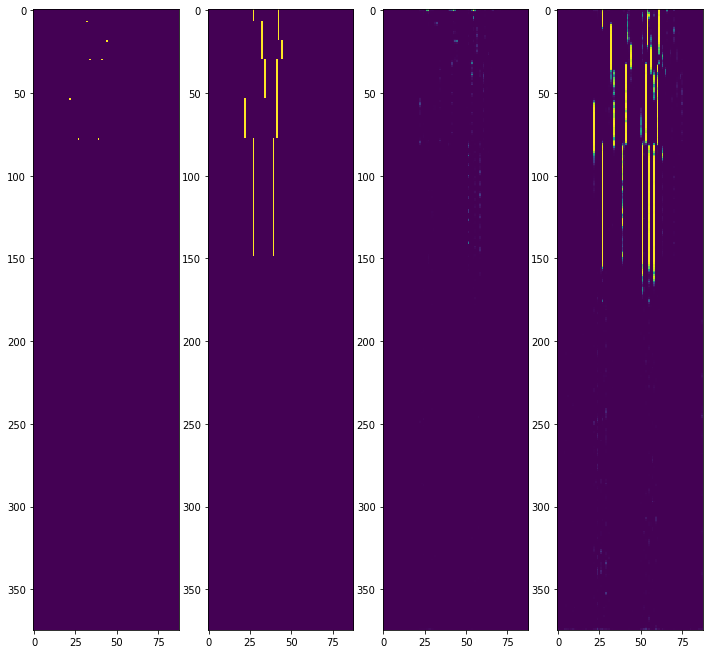

In [16]:
import math
from preprocess import clip_and_spectrum, convert_midi_to_mp3, convert_midi_to_label, label_clip_to_onehot


file = "/home/kialan/Document/tools/crawler/midi_crawler/outputs/albinoni-trattenimenti-armonici-no10-iii-adagio.mid"
label = convert_midi_to_label(file, 'tmp.label')
label = [eval(i) for i in open('tmp.label')]

convert_midi_to_mp3(file, 'tmp.mp3')
mp3 = np.array(AudioSegment.from_mp3('tmp.mp3').get_array_of_samples()) / 32768
mp3 = np.concatenate([np.zeros(44100), mp3])  # add 1s offset
len_clip = 15 * 44100
n_clip = math.ceil(len(mp3) / len_clip)
mp3 = np.concatenate([mp3, np.zeros(n_clip * len_clip - len(mp3))])  # pad 0

label = [label_clip_to_onehot(label, clip, offset_ms=1000) for clip in range(n_clip)]
spec = [spectrum(mp3[clip * len_clip:(clip + 1) * len_clip], n_bins=352) for clip in range(n_clip)]

for i, x in zip(label, spec):
    plt.figure(figsize=(12,12))
    plt.subplot(141); plt.imshow(i[0])
    plt.subplot(142); plt.imshow(i[1])
    
    x = torch.Tensor(x).cuda()[:1500]
    x.unsqueeze_(0)
    x.unsqueeze_(0)
    ypred = net(x).cpu().data[0]
    plt.subplot(143); plt.imshow(ypred[0])
    plt.subplot(144); plt.imshow(ypred[1])
    plt.show()

    plt.show()


In [8]:
x.shape

torch.Size([1, 1, 1500, 352])